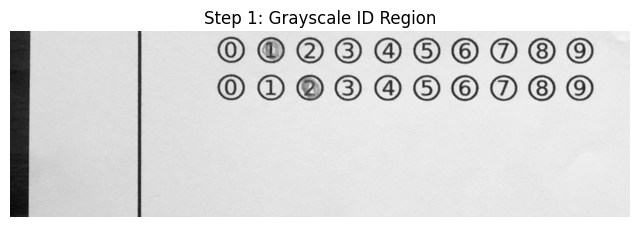

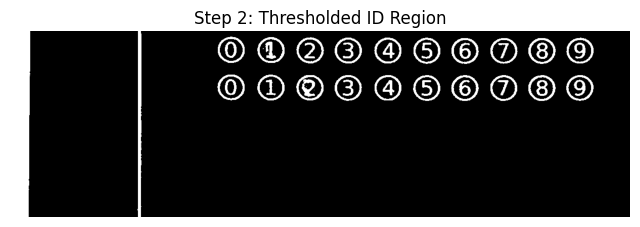

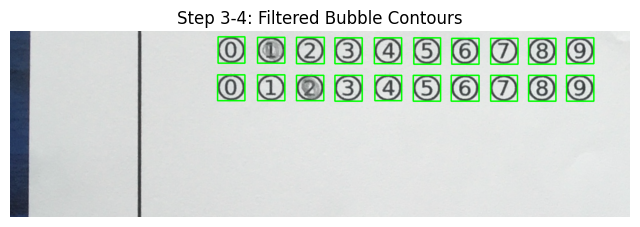

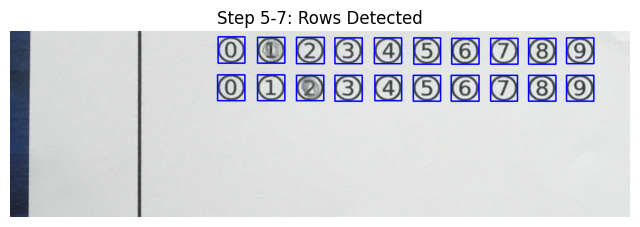

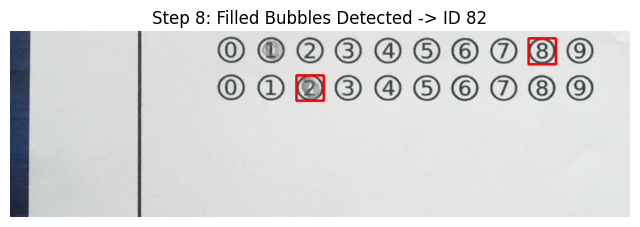

Detected ID: 82


In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import imutils
from paperExtraction import *

def show_image(img, title=""):
    """Display image inline with matplotlib"""
    plt.figure(figsize=(8,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

def detect_id_contours(id_image, num_digits, min_size=10, aspect_ratio_tol=0.2):
    """
    Detect student ID using contours.

    Args:
        id_image: Cropped ID region (BGR)
        num_digits: Number of digits in the ID
        min_size: Minimum width/height of bubble
        aspect_ratio_tol: Allowed deviation from perfect square

    Returns:
        id_number: Detected ID as string
    """
    # Step 1: Grayscale
    gray = cv2.cvtColor(id_image, cv2.COLOR_BGR2GRAY)
    show_image(gray, "Step 1: Grayscale ID Region")

    # Step 2: Threshold (Otsu + Binary Inverted)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    show_image(thresh, "Step 2: Thresholded ID Region")

    # Step 3: Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Step 4: Filter contours by size and aspect ratio
    bubbleCnts = []
    debug_img = id_image.copy()
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        ar = w / float(h)
        if w >= min_size and h >= min_size and abs(ar - 1) <= aspect_ratio_tol:
            bubbleCnts.append(c)
            cv2.rectangle(debug_img, (x,y), (x+w, y+h), (0,255,0), 2)
    show_image(debug_img, "Step 3-4: Filtered Bubble Contours")

    # Step 5: Sort contours top-to-bottom
    bubbleCnts = contours.sort_contours(bubbleCnts, method="top-to-bottom")[0]

    # Step 6: Split contours into rows
    rows = []
    current_row = []
    tolerance = 10  # pixels
    for c in bubbleCnts:
        x, y, w, h = cv2.boundingRect(c)
        if not current_row:
            current_row.append(c)
            last_y = y
        elif abs(y - last_y) <= tolerance:
            current_row.append(c)
        else:
            rows.append(sorted(current_row, key=lambda b: cv2.boundingRect(b)[0]))  # left-to-right
            current_row = [c]
            last_y = y
    if current_row:
        rows.append(sorted(current_row, key=lambda b: cv2.boundingRect(b)[0]))

    # Keep only first num_digits rows
    rows = rows[:num_digits]

    # Step 7: Draw rows for debug
    row_img = id_image.copy()
    for row in rows:
        for c in row:
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(row_img, (x,y), (x+w, y+h), (255,0,0), 2)
    show_image(row_img, "Step 5-7: Rows Detected")

    # Step 8: Detect filled bubble in each row
    id_number = ""
    filled_img = id_image.copy()
    for row in rows:
        max_filled = 0
        filled_choice = None
        for idx, c in enumerate(row):
            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            total = cv2.countNonZero(cv2.bitwise_and(thresh, thresh, mask=mask))
            if total > max_filled:
                max_filled = total
                filled_choice = idx
        id_number += str(filled_choice)
        # Draw filled bubble in red
        x, y, w, h = cv2.boundingRect(row[filled_choice])
        cv2.rectangle(filled_img, (x,y), (x+w, y+h), (0,0,255), 3)
    show_image(filled_img, f"Step 8: Filled Bubbles Detected -> ID {id_number}")

    return id_number

# -------------------------------
# Example usage
# -------------------------------
imagePath = "../data/images/13.jpg"
paper = extractPaper(imagePath)
height, width, channels = paper.shape
num_digits = 2  # set the number of digits in your ID
id_image = paper[height//8:height//4, :5*width//9, :]
student_id = detect_id_contours(id_image, num_digits)
print("Detected ID:", student_id)
